## Time to get you hands dirty!  Position of a quasar

You measure the position of a quasar $N$ times with the *same* telescope i.e. errors are homoscedastic. Let's say the underlying process is Gaussian, the true position is $\mu = 1$ (in suitable units), and the erorrs are $\sigma=0.2$

### Part 1

- Generate fake measurements. Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.
- Plot each of the individual likelihoods separately.  Also plot their product (i.e. the likelihood of the dataset $\{x_i\}$). Make sure the x grid has enough points.
- Just read off the maximum likelihood solution (e.g. using `np.argsort`) 
- Compare it with the MLE estimator derived above

### Part 2

Check the Fisher matrix error estimate makes sense
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.
- Compare with the Fisher matrix error derived above
- Plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution. (The normalization won't be captured, you can rescale it as you like to check it agrees) 

### Part 3

Let's make our model more realistic. Our $N$ measurements were taken in different nights, where the sky behaved differently (i.e. errors are heteoscedastic). Let's assume that each measurment has a $\sigma_i$ that is normally distribured with mean $0.2$ and standard deviation $0.05$

- Generalize your code from above to this case

In [1]:
import numpy as np
from astroML.datasets import fetch_dr7_quasar
from matplotlib import pyplot as plt
import scipy.stats
import scipy.interpolate as interpolate
from scipy.interpolate import splev, splrep
import astropy
from scipy.stats import norm

### 1. Plotting Underlying Distribution

We want to compare the MLE and the maximum likelihood value. In order to do that, we choose an underlying process distribution and sample 5 points from it.

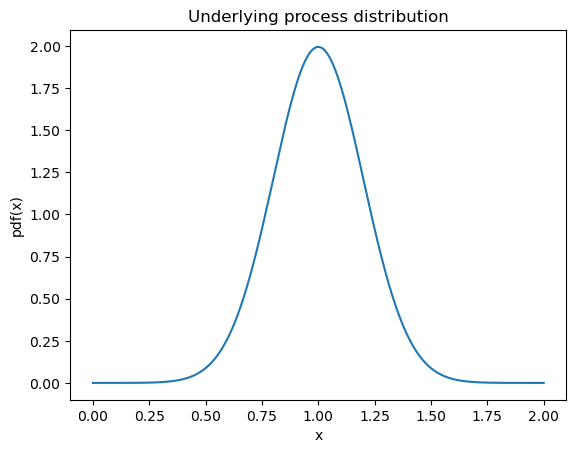

In [2]:
mean = 1
sigma = 0.2
#np.random.seed(42) 
N = 5
gaussian = scipy.stats.norm(loc = mean, scale = sigma)
ax = plt.gca()
x = scipy.stats.norm.rvs(loc = mean, scale = sigma, size = N)
x.sort()
x_lin = np.linspace(0,2,1000)
ax.plot(x_lin, gaussian.pdf(x_lin))
plt.title('Underlying process distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.show()

### 2. Likelihood Analysis for Homoedastic Errors

From our samples, we can compute their likelihoods to obtain the total likelihood from their product. Then, after taking its logarithm, we can obtain an estimate of the $\mu$ and the $\sigma$ of the underlying process distribution from its maximum. Finally, we can compare the result obtained from the likelihood with the MLE formulas.

#### 2.1 Computing Single Likelihoods and their Product

Firstly, we compute the likelihood of each sample and their resulting product.

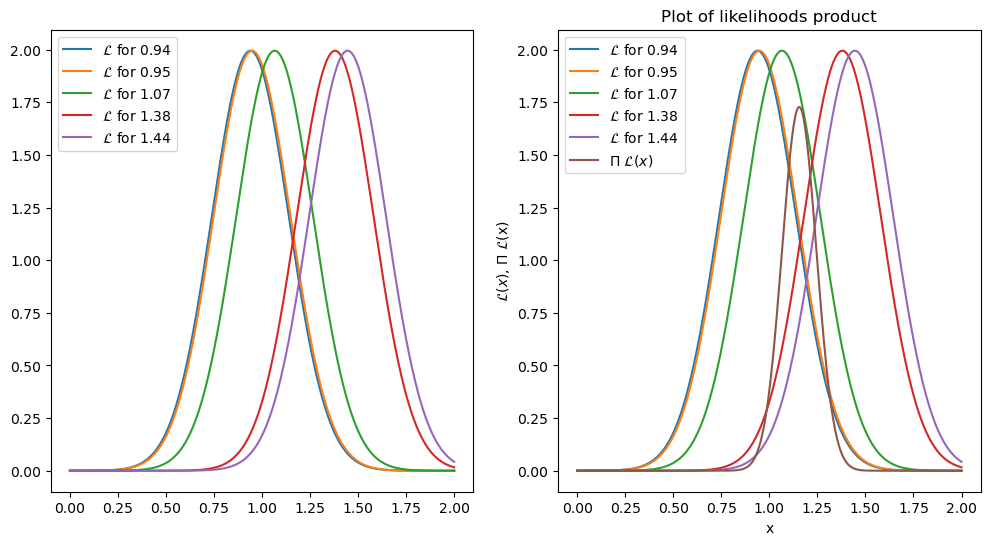

In [3]:
tot_likelihood = 1

#choose if homodastic or heterodastic errors 
sigma_x = np.full(N, sigma)
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for value, sigma_value in zip(x,sigma_x):
    gauss = scipy.stats.norm(loc = value, scale = sigma_value)
    ax.plot(x_lin, gauss.pdf(x_lin), label = '$\mathcal{L}$ for %.02f' %value)
    ax1.plot(x_lin, gauss.pdf(x_lin), label = '$\mathcal{L}$ for %.02f' %value)
    tot_likelihood = tot_likelihood*gauss.pdf(x_lin)

ax.legend()
plt.title('Plot of single likelihoods')
plt.xlabel('x')
plt.ylabel(r'$\mathcal{L}$(x)')

ax1.plot(x_lin, tot_likelihood, label = r'$\Pi$ $\mathcal{L}(x)$')
ax1.legend()
plt.title('Plot of likelihoods product')
plt.xlabel('x')
plt.ylabel(r'$\mathcal{L}(x)$, $\Pi$ $\mathcal{L}$(x)')
plt.show()

#### 2.2 Computing Maximum Likelihood

Once we computed the likelihood, we can obtain the maximum likelihood to estimate our mean $\mu$.

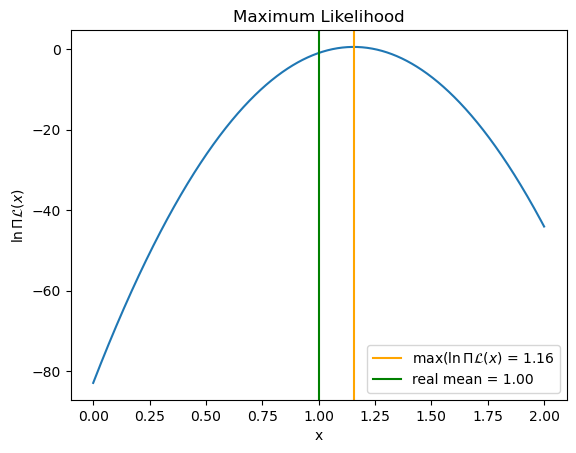

In [4]:
ax = plt.gca()
tot_likelihood = np.log(tot_likelihood)
ax.plot(x_lin, tot_likelihood)   
findmax = x_lin[np.argmax(tot_likelihood)]
ax.axvline(findmax, label = r'max($\ln{\Pi\mathcal{L}(x)}$ = %.02f' % findmax, color = 'orange')
ax.axvline(mean, label = 'real mean = %.02f' % mean, color = 'green')
plt.title('Maximum Likelihood')
plt.xlabel('x')
plt.ylabel(r'$\ln{\Pi\mathcal{L}(x)}$')
plt.legend()
plt.show()

#### 2.3 Comparison between Maximum Likelihood, Fisher Matrix and corresponding MLE estimators

From the fisher matrix, we can also obtain $\sigma$. This way, we can compare the estimates for $\mu$ and $\sigma$ computed from the samples and the estimates obtained from the MLE formulations.

In [5]:
MLE_mean = sum(x/sigma_x**2)/sum(1/sigma_x**2)
print('Comparison between max of the likelihood and MLE estimator: %.03f, %.03f' % (findmax, MLE_mean))

fisher = 1/np.sqrt(- np.diff(tot_likelihood,n=2)[np.argmax(tot_likelihood)]/(x_lin[1]-x_lin[0])**2)
MLE_fisher = sum(1/sigma_x**2)**(-1/2)
print('Comparison between fisher matrix and MLE estimator: %.03f, %.03f' %(fisher, MLE_fisher))

Comparison between max of the likelihood and MLE estimator: 1.155, 1.155
Comparison between fisher matrix and MLE estimator: 0.089, 0.089


#### 2.4 Comparison between Likelihood obtained from Sampling and Likelihood from MLE 

We can also visualize this comparison by plotting the corresponding gaussian for each method.

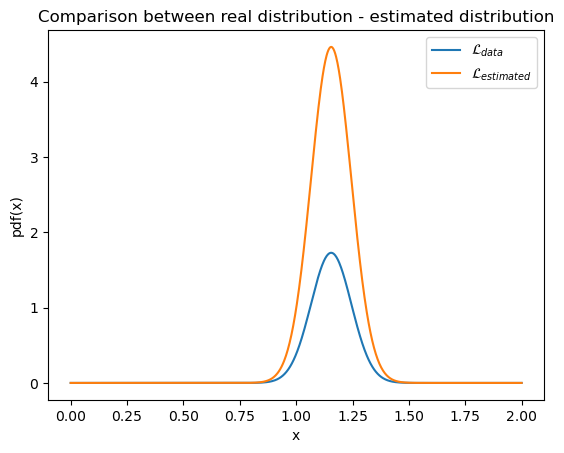

In [6]:
estimated_gaussian = scipy.stats.norm(loc = MLE_mean, scale = MLE_fisher)
x_lin = np.linspace(0,2,1000)

ax = plt.gca()
ax.plot(x_lin, np.exp(tot_likelihood), label = '$\mathcal{L}_{data}$')
ax.plot(x_lin, estimated_gaussian.pdf(x_lin), label = '$\mathcal{L}_{estimated}$')
plt.title('Comparison between real distribution - estimated distribution')
plt.xlabel('x')
plt.legend()
plt.ylabel('pdf(x)');

### 3. Likelihood Analysis for Heterodastic Errors

The MLE formulation used here is valid also for heterodastic errors. We can show this by repeating the steps attributing at each sample a different $\sigma$. In particular, we extract the various $\sigma$ from a gaussian centered in $0.2$ with scale $0.05$.

#### 3.1 Computing Single Likelihoods and their Product

Firstly, we compute the likelihood of each sample and their resulting product.

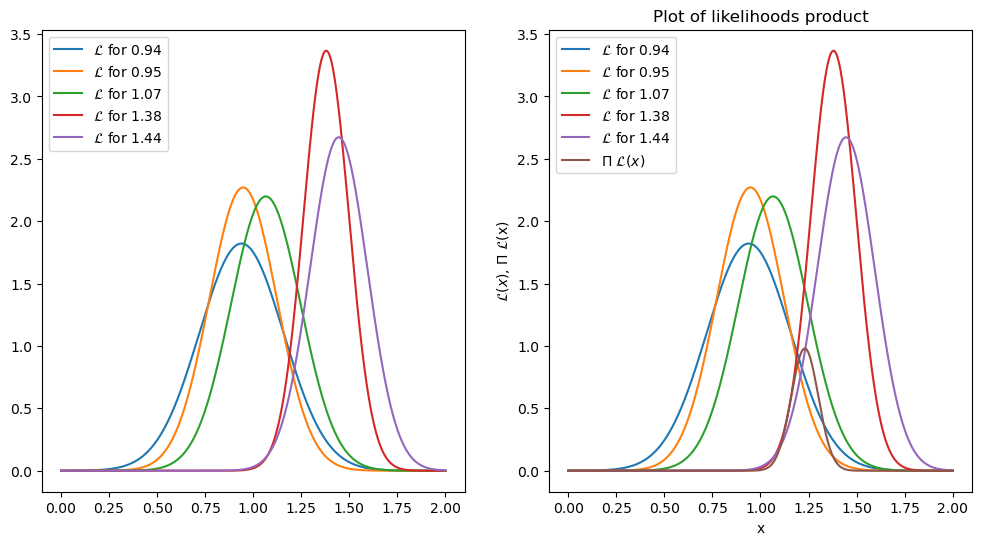

In [7]:
tot_likelihood = 1

sigma_x = np.abs(scipy.stats.norm.rvs(loc = 0.2, scale = 0.05, size = N))
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for value, sigma_value in zip(x,sigma_x):
    gauss = scipy.stats.norm(loc = value, scale = sigma_value)
    ax.plot(x_lin, gauss.pdf(x_lin), label = '$\mathcal{L}$ for %.02f' %value)
    ax1.plot(x_lin, gauss.pdf(x_lin), label = '$\mathcal{L}$ for %.02f' %value)
    tot_likelihood = tot_likelihood*gauss.pdf(x_lin)

ax.legend()
plt.title('Plot of single likelihoods')
plt.xlabel('x')
plt.ylabel(r'$\mathcal{L}$(x)')

ax1.plot(x_lin, tot_likelihood, label = r'$\Pi$ $\mathcal{L}(x)$')
ax1.legend()
plt.title('Plot of likelihoods product')
plt.xlabel('x')
plt.ylabel(r'$\mathcal{L}(x)$, $\Pi$ $\mathcal{L}$(x)')
plt.show()

#### 3.2 Computing Maximum Likelihood

Once we computed the likelihood, we can obtain the maximum likelihood to estimate our mean $\mu$.

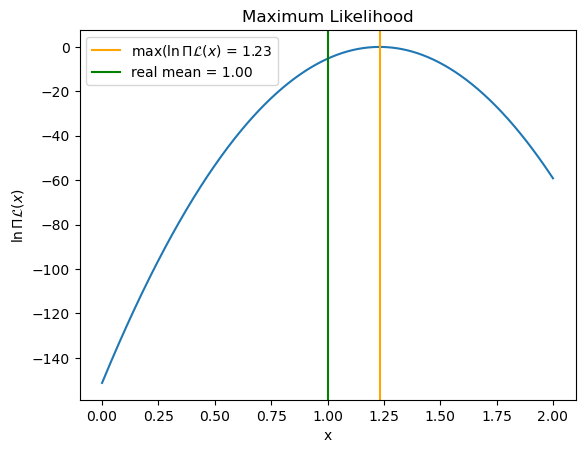

In [8]:
ax = plt.gca()
tot_likelihood = np.log(tot_likelihood)
ax.plot(x_lin, tot_likelihood)   
findmax = x_lin[np.argmax(tot_likelihood)]
ax.axvline(findmax, label = r'max($\ln{\Pi\mathcal{L}(x)}$ = %.02f' % findmax, color = 'orange')
ax.axvline(mean, label = 'real mean = %.02f' % mean, color = 'green')
plt.title('Maximum Likelihood')
plt.xlabel('x')
plt.ylabel(r'$\ln{\Pi\mathcal{L}(x)}$')
plt.legend()
plt.show()

#### 3.3 Comparison between Maximum Likelihood, Fisher Matrix and corresponding MLE estimators

From the fisher matrix, we can also obtain $\sigma$. This way, we can compare the estimates for $\mu$ and $\sigma$ computed from the samples and the estimates obtained from the MLE formulations.

In [9]:
MLE_mean = sum(x/sigma_x**2)/sum(1/sigma_x**2)
print('Comparison between max of the likelihood and MLE estimator: %.03f, %.03f' % (findmax, MLE_mean))

fisher = 1/np.sqrt(- np.diff(tot_likelihood,n=2)[np.argmax(tot_likelihood)]/(x_lin[1]-x_lin[0])**2)
MLE_fisher = sum(1/sigma_x**2)**(-1/2)
print('Comparison between fisher matrix and MLE estimator: %.03f, %.03f' %(fisher, MLE_fisher))

Comparison between max of the likelihood and MLE estimator: 1.231, 1.231
Comparison between fisher matrix and MLE estimator: 0.071, 0.071


#### 3.4 Comparison between Likelihood obtained from Sampling and Likelihood from MLE 

We can also visualize this comparison by plotting the corresponding gaussian for each method.

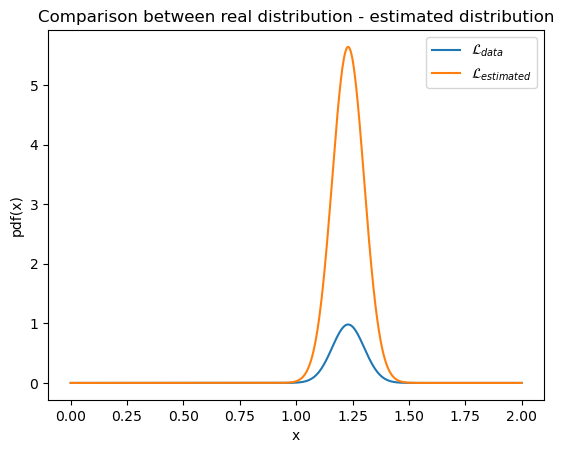

In [10]:
estimated_gaussian = scipy.stats.norm(loc = MLE_mean, scale = MLE_fisher)
x_lin = np.linspace(0,2,1000)

ax = plt.gca()
ax.plot(x_lin, np.exp(tot_likelihood), label = '$\mathcal{L}_{data}$')
ax.plot(x_lin, estimated_gaussian.pdf(x_lin), label = '$\mathcal{L}_{estimated}$')
plt.title('Comparison between real distribution - estimated distribution')
plt.xlabel('x')
plt.legend()
plt.ylabel('pdf(x)');